In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from skforecast.ForecasterAutoreg import ForecasterAutoreg

In [2]:
# Data processing
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
# Modelling and Forecasting
# ==============================================================================
import xgboost
import skforecast
import sklearn
from xgboost import XGBRegressor
from sklearn.feature_selection import RFECV
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import bayesian_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import random_search_forecaster

# Warnings configuration
# ==============================================================================
import warnings
warnings.filterwarnings('once')


C:\Users\grego\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
data = pd.read_csv("datos_preprocesados.csv", parse_dates=['fecha'], index_col='fecha')
data = data.asfreq('D')

In [4]:
# Split train-validation-test
# ==============================================================================
end_train = '2021-12-31'
end_validation = '2022-12-31'
data_train = data.loc[: end_train, :]
data_val   = data.loc[end_train:end_validation, :]
data_test  = data.loc[end_validation:, :]

print(f"Dates train      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Dates validacion : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Dates test       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Dates train      : 2019-01-01 00:00:00 --- 2021-12-31 00:00:00  (n=1096)
Dates validacion : 2021-12-31 00:00:00 --- 2022-12-31 00:00:00  (n=366)
Dates test       : 2022-12-31 00:00:00 --- 2024-09-18 00:00:00  (n=628)


In [6]:
# Create forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = DecisionTreeRegressor(random_state=15926),
                 lags      = 7
             )

# Train forecaster
# ==============================================================================
forecaster.fit(y=data.loc[:end_validation, 'demanda'])
forecaster

ForecasterAutoreg 
Regressor: DecisionTreeRegressor(random_state=15926) 
Lags: [1 2 3 4 5 6 7] 
Transformer for y: None 
Transformer for exog: None 
Window size: 7 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2019-01-01 00:00:00'), Timestamp('2022-12-31 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 15926, 'splitter': 'best'} 
fit_kwargs: {} 
Creation date: 2024-10-07 23:14:55 
Last fit date: 2024-10-07 23:14:55 
Skforecast version: 0.9.1 
Python version: 3.7.4 
Forecaster id: None 

In [9]:
exog_features = ['tmed', 'diasem', 'trim', 'festivo', 'hrmedia']

# Backtesting model with exogenous variables on test data
# ==============================================================================
metric, predictions = backtesting_forecaster(
    forecaster         = forecaster,
    y                  = data['demanda'],
    exog               = data[exog_features],
    steps              = 1,
    metric             = 'mean_absolute_error',
    initial_train_size = len(data[:end_validation]),
    refit              = False,
    n_jobs             = 'auto',
    verbose            = False,
    show_progress      = True
)

print(metric)

  0%|          | 0/627 [00:00<?, ?it/s]

996.0867304625198


## Bayesian optimizator

In [11]:
forecaster = ForecasterAutoreg(
    regressor = DecisionTreeRegressor(random_state=15926),
    lags      = 7
)

# Lags grid
lags_grid = [7]

# Regressor hyperparameters search space para DecisionTreeRegressor
def search_space(trial):
    search_space = {
        'max_depth'       : trial.suggest_int('max_depth', 3, 20, step=1),          # Profundidad máxima del árbol
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20, step=1), # Mínimo de muestras para dividir un nodo
        'min_samples_leaf' : trial.suggest_int('min_samples_leaf', 1, 10, step=1),  # Mínimo de muestras por hoja
        'max_features'    : trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2', None])  # Número máximo de características a considerar
 
    }
    return search_space


results_search, frozen_trial = bayesian_search_forecaster(
    forecaster         = forecaster,
    y                  = data.loc[:end_validation, 'demanda'],
    exog               = data.loc[:end_validation, exog_features],
    search_space       = search_space,
    steps              = 1,
    refit              = False,
    metric             = 'mean_absolute_error',
    initial_train_size = len(data_train),
    fixed_train_size   = False,
    n_trials           = 50,
    random_state       = 123,
    return_best        = True,
    n_jobs             = 'auto',
    verbose            = False,
)
best_params = results_search['params'].iat[0]
best_lags = results_search['lags'].iat[0]

Number of models compared: 50,
         50 bayesian search in each lag configuration.


lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6 7] 
  Parameters: {'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 9, 'max_features': 'log2'}
  Backtesting metric: 972.1060857087651



C:\Users\grego\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\grego\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\grego\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\grego\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: Fu

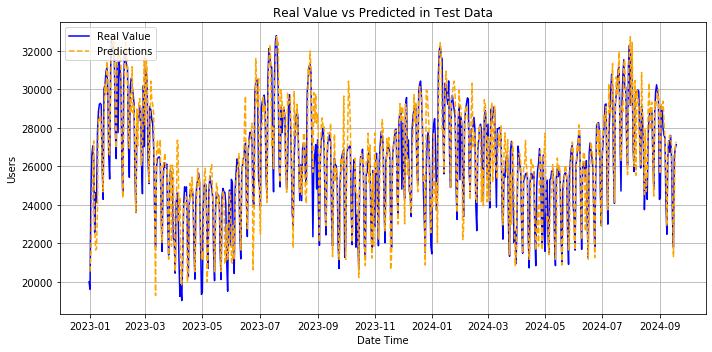

In [12]:
import matplotlib.pyplot as plt

# Plot predictions vs real value
# ======================================================================================
plt.figure(figsize=(10, 5))  # Define el tamaño de la figura

# Graficar los valores reales
plt.plot(data_test.index, data_test['demanda'], label="Real Value", color='blue', linestyle='-')

# Graficar las predicciones
plt.plot(predictions.index, predictions['pred'], label="Predictions", color='orange', linestyle='--')

# Configurar el título y las etiquetas
plt.title("Real Value vs Predicted in Test Data")
plt.xlabel("Date Time")
plt.ylabel("Users")

# Añadir leyenda
plt.legend(loc='upper left')

# Mostrar el gráfico
plt.grid()  # Añadir cuadrícula para mejor visualización
plt.tight_layout()  # Ajustar el layout
plt.show()
